# Project: Identify Customer Segments
### Eleftherios Kokkinis

In this project I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%matplotlib inline

### The Data

There are four files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.


In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';',)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [6]:
print("Shape of Demographic data for general population:", azdias.shape)
print("Shape of Feature Summary for degmographic data:", feat_info.shape)

Shape of Demographic data for general population: (790977, 85)
Shape of Feature Summary for degmographic data: (85, 4)


In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,790977.000000,790977.000000,790977.000000,786641.000000,790977.000000,790977.000000,790977.000000,790977.000000,790977.000000,790977.000000,...,687224.000000,687224.000000,687224.000000,687224.000000,687224.000000,687224.000000,687224.000000,704523.000000,704523.000000,704523.000000
mean,-0.358937,2.777138,1.522494,3.633513,3.075366,2.821661,3.400996,3.033845,2.876366,3.072188,...,2.254159,2.801966,1.594729,0.698384,1.941889,3.613173,3.382663,3.166611,5.291746,3.072382
std,1.198647,1.069147,0.499494,1.595151,1.321039,1.464268,1.321817,1.529282,1.486792,1.353142,...,0.971716,0.919759,0.986572,0.726600,1.458396,0.974126,1.110899,1.002739,2.303396,1.363482
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



## Preprocessing

### Assessing Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help you make cleaning decisions during this stage of the project. 

####  Converting Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [11]:
for i in range(len(feat_info)):
    string=feat_info["missing_or_unknown"][i][1:len(feat_info["missing_or_unknown"][i])-1]
    List=string.split(',')
    
    manual_list=[]
        
        
    for j in List:
        try:
            x=int(j)
            manual_list.append(x)
        except:
            manual_list.append(j)
    feat_info["missing_or_unknown"][i]=manual_list
                

In [12]:
for i in range(len(feat_info)):
    for j in feat_info["missing_or_unknown"][i]:
        azdias[azdias.columns[i]]=azdias[azdias.columns[i]].replace(j,np.nan)

In [13]:
print('Total number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))

Total number of missing values after conversion is 7441901


In [14]:
# Performing an assessment of how much missing data there is in each column of the
# dataset.
azdias.isna().sum()


AGER_TYP                608876
ALTERSKATEGORIE_GROB      2580
ANREDE_KZ                    0
CJT_GESAMTTYP             4336
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                103753
PLZ8_GBZ                103753
ARBEIT                   86593
ORTSGR_KLS9              86503
RELAT_AB                 86593
Length: 85, dtype: int64

In [15]:
# Investigate patterns in the amount of missing data in each column.

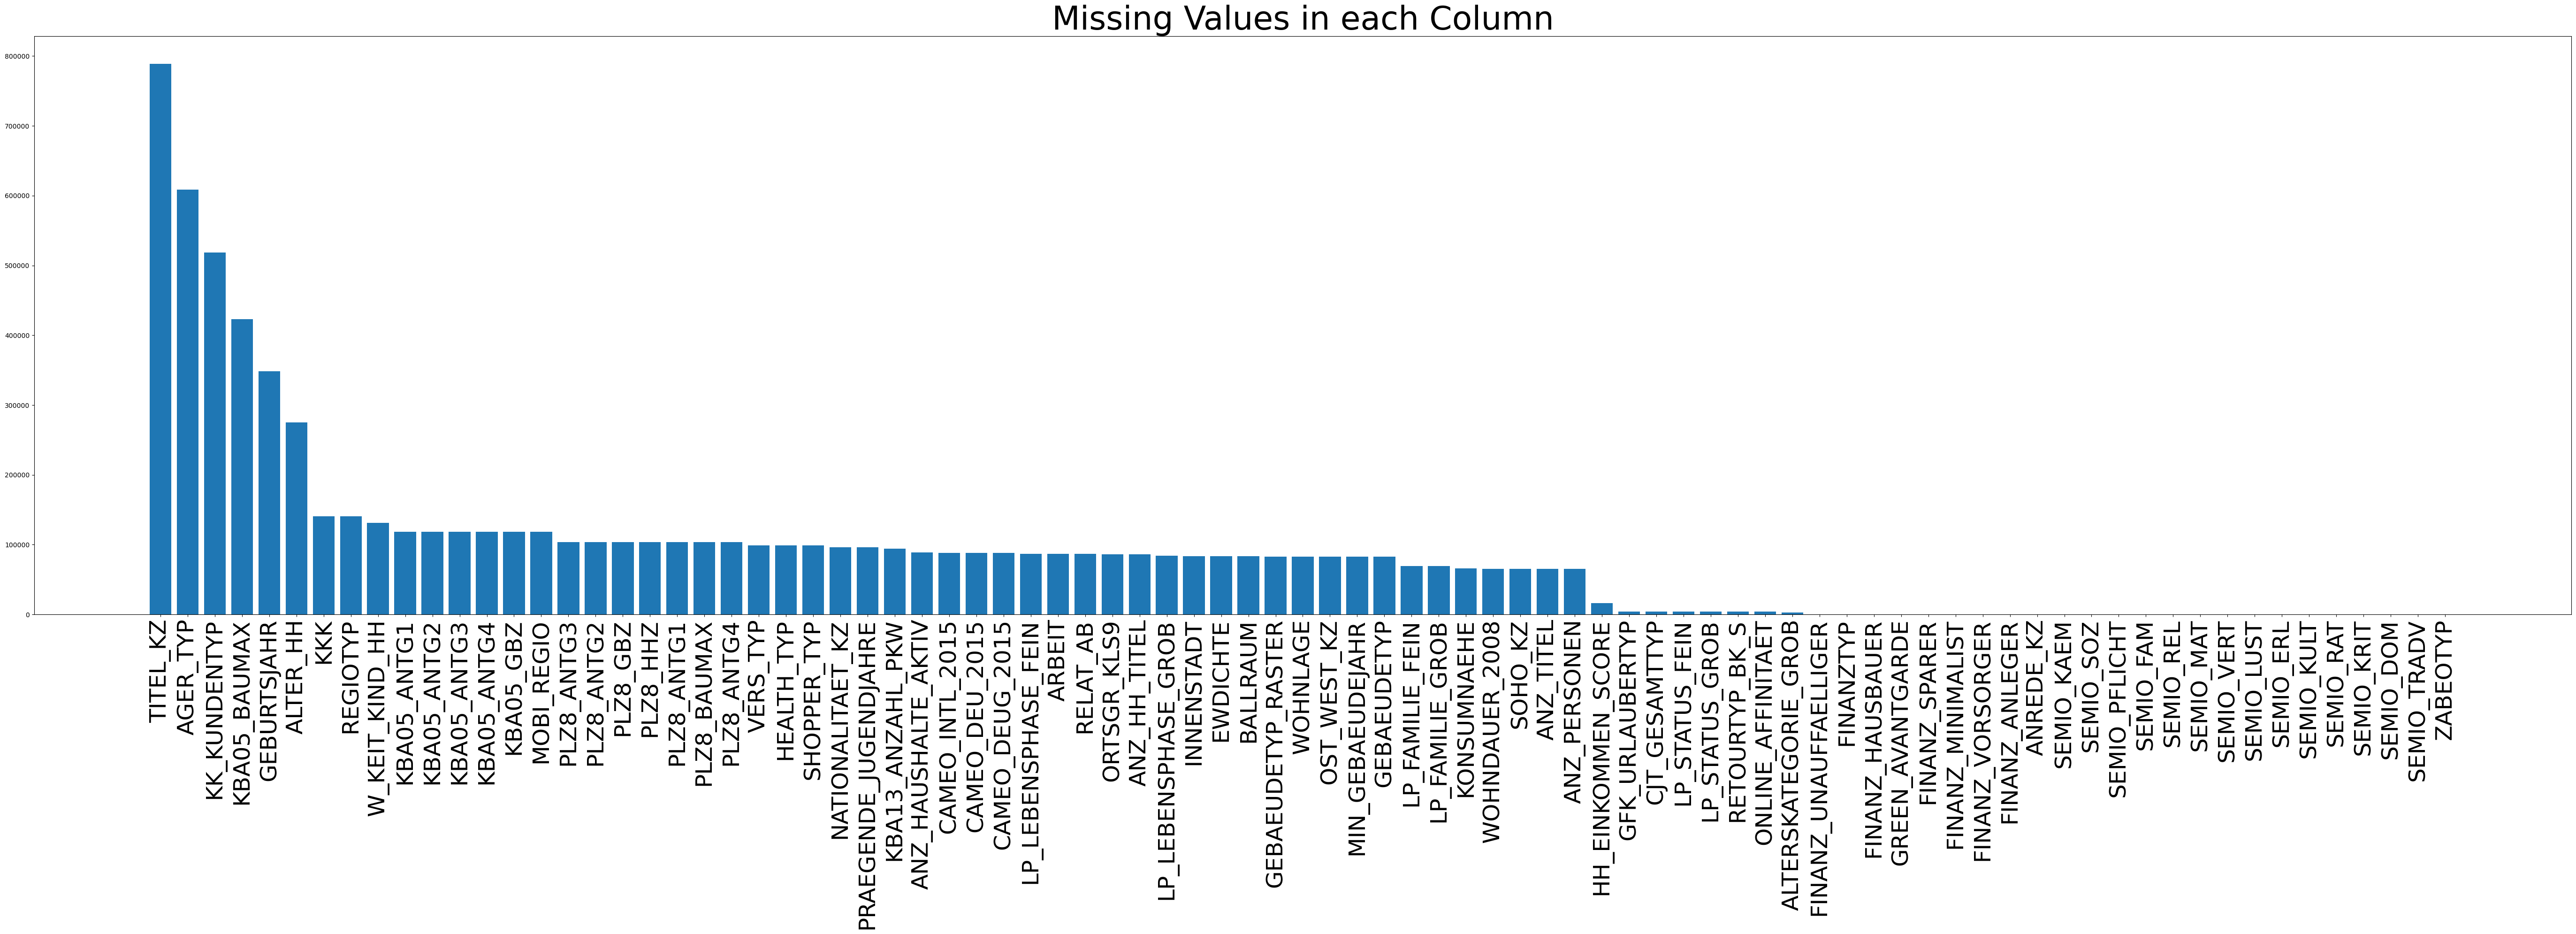

In [16]:
x=azdias.isna().sum()
plt.figure(figsize=(55,20))
plt.bar(x.sort_values(ascending=False).index,x.sort_values(ascending=False).values)
plt.xticks(rotation=90,size=35)
plt.title('Missing Values in each Column',size=50)
plt.tight_layout()
plt.show();

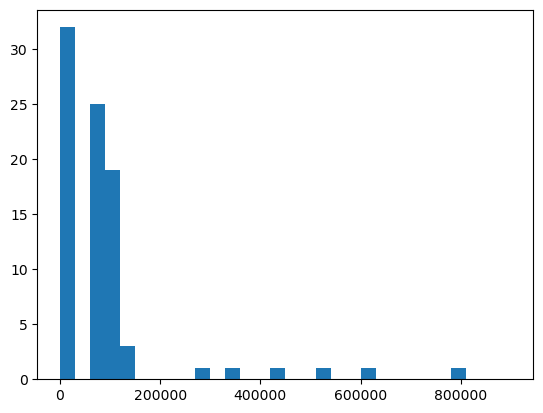

In [17]:
plt.hist(x.values,bins=30,range=(0,900000));

In [18]:
Most_Missing=x.nlargest(6)
print(Most_Missing)

TITEL_KZ        789083
AGER_TYP        608876
KK_KUNDENTYP    518845
KBA05_BAUMAX    423195
GEBURTSJAHR     348132
ALTER_HH        275367
dtype: int64


In [19]:
#I am double checking those findings by creating a sorted dictionary with the percentage of missing values
#per column

percentage_of_nans={}
for i in azdias.columns:
    percentage_of_nans[i]=azdias[i].isna().sum()/len(azdias[i])
sorted_keys=sorted(percentage_of_nans,key=percentage_of_nans.get)
sorted_percentage={}
for w in sorted_keys:
    sorted_percentage[w]=percentage_of_nans[w]

In [20]:
#showing the dictionary. As we can see, the highest % columns are the same with the outliers
#that we found before.
sorted_percentage

{'ANREDE_KZ': 0.0,
 'FINANZ_MINIMALIST': 0.0,
 'FINANZ_SPARER': 0.0,
 'FINANZ_VORSORGER': 0.0,
 'FINANZ_ANLEGER': 0.0,
 'FINANZ_UNAUFFAELLIGER': 0.0,
 'FINANZ_HAUSBAUER': 0.0,
 'FINANZTYP': 0.0,
 'GREEN_AVANTGARDE': 0.0,
 'SEMIO_SOZ': 0.0,
 'SEMIO_FAM': 0.0,
 'SEMIO_REL': 0.0,
 'SEMIO_MAT': 0.0,
 'SEMIO_VERT': 0.0,
 'SEMIO_LUST': 0.0,
 'SEMIO_ERL': 0.0,
 'SEMIO_KULT': 0.0,
 'SEMIO_RAT': 0.0,
 'SEMIO_KRIT': 0.0,
 'SEMIO_DOM': 0.0,
 'SEMIO_KAEM': 0.0,
 'SEMIO_PFLICHT': 0.0,
 'SEMIO_TRADV': 0.0,
 'ZABEOTYP': 0.0,
 'ALTERSKATEGORIE_GROB': 0.0032617889015736233,
 'CJT_GESAMTTYP': 0.005481828169466369,
 'GFK_URLAUBERTYP': 0.005481828169466369,
 'LP_STATUS_FEIN': 0.005481828169466369,
 'LP_STATUS_GROB': 0.005481828169466369,
 'RETOURTYP_BK_S': 0.005481828169466369,
 'ONLINE_AFFINITAET': 0.005481828169466369,
 'HH_EINKOMMEN_SCORE': 0.020668110450746357,
 'SOHO_KZ': 0.08263957106211685,
 'ANZ_PERSONEN': 0.08263957106211685,
 'ANZ_TITEL': 0.08263957106211685,
 'WOHNDAUER_2008': 0.082639571062116

In [21]:
x.describe()

count        85.000000
mean      87551.776471
std      130136.980932
min           0.000000
25%           0.000000
50%       82858.000000
75%      103753.000000
max      789083.000000
dtype: float64

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)



In [23]:
#Drop the outliers

for column in Most_Missing.index:
    azdias.drop(labels=column,axis=1,inplace=True)
azdias.shape

(790977, 79)

In [24]:
m=azdias.isnull().sum()

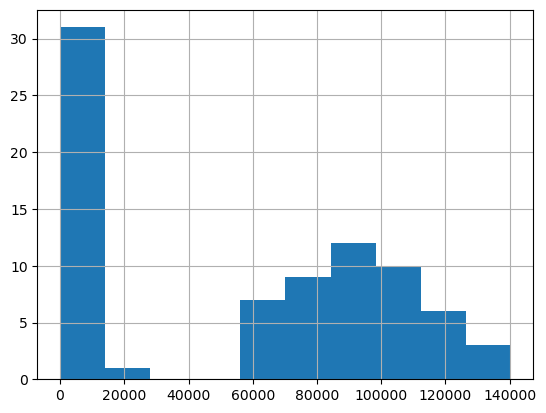

In [25]:
m.hist();

In [26]:
y=m.value_counts()
print(y)

0         24
103753     7
4336       6
118629     6
65366      4
82858      4
88269      3
98866      3
83344      3
86593      2
69164      2
140371     2
2580       1
93998      1
82865      1
88596      1
65799      1
86280      1
131432     1
16348      1
96163      1
96286      1
84094      1
86809      1
86503      1
dtype: int64


In [27]:
#I create a dictionary with the groups of features that appear to have the same amount of missing values
# Just in case I may need to refer to it later

dict_of_missing={}
for index in y.head(12).index:
    for i in range(len(x)):
        if index==x.values[i]:
            if index not in dict_of_missing:
                dict_of_missing[index]=[]
                dict_of_missing[index].append(x.index[i])
            else:
                dict_of_missing[index].append(x.index[i])

In [28]:
dict_of_missing

{0: ['ANREDE_KZ',
  'FINANZ_MINIMALIST',
  'FINANZ_SPARER',
  'FINANZ_VORSORGER',
  'FINANZ_ANLEGER',
  'FINANZ_UNAUFFAELLIGER',
  'FINANZ_HAUSBAUER',
  'FINANZTYP',
  'GREEN_AVANTGARDE',
  'SEMIO_SOZ',
  'SEMIO_FAM',
  'SEMIO_REL',
  'SEMIO_MAT',
  'SEMIO_VERT',
  'SEMIO_LUST',
  'SEMIO_ERL',
  'SEMIO_KULT',
  'SEMIO_RAT',
  'SEMIO_KRIT',
  'SEMIO_DOM',
  'SEMIO_KAEM',
  'SEMIO_PFLICHT',
  'SEMIO_TRADV',
  'ZABEOTYP'],
 103753: ['PLZ8_ANTG1',
  'PLZ8_ANTG2',
  'PLZ8_ANTG3',
  'PLZ8_ANTG4',
  'PLZ8_BAUMAX',
  'PLZ8_HHZ',
  'PLZ8_GBZ'],
 4336: ['CJT_GESAMTTYP',
  'GFK_URLAUBERTYP',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'RETOURTYP_BK_S',
  'ONLINE_AFFINITAET'],
 118629: ['KBA05_ANTG1',
  'KBA05_ANTG2',
  'KBA05_ANTG3',
  'KBA05_ANTG4',
  'KBA05_GBZ',
  'MOBI_REGIO'],
 65366: ['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'],
 82858: ['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'],
 88269: ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'],
 98866: ['HEAL

#### Discussion: Assess Missing Data in Each Column

From the bar graph above we observe that there are 6 columns/features with significantly more missing values than the rest. Those are the outliers that will be removed:

TITEL_KZ        889061, 
AGER_TYP        685843, 
KK_KUNDENTYP    584612, 
KBA05_BAUMAX    476524, 
GEBURTSJAHR     392318, 
ALTER_HH        310267

In addition, from the first histogram and the examination of the data we are able to see that most labels have missing values up to ~117.000 and their distribution is positively skewd. The 6 outliers are again visible towards the tail of the distribution.

After dropping the outliers, we notice in the second histogram that there's a dense group of labels around 0 missing values and a group around 60000-160000 that seem to follow a normal distribution and then they are being verified by checking their percentages

By looking further into them we notice that there are several clusters of features with the same exact number of missing values. Those are features that may have something in common and we stored them in the dictionary dict_of_missing just in case we need them later.
24 of them appear to have exact 0 missing values which mostly explains the first dense group in the second histogram.
We also notice that their names in each group are very similar and by checking the data_dictionary file we can verify that they are talking about the same thing (eg financial,family,personality typologies etc).



#### Assessing Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. 

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special.

0    43
1     0
2     0
3     7
4     0
dtype: int64


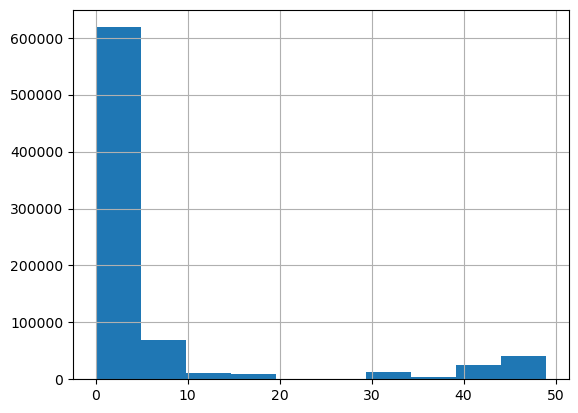

In [29]:
# How much data is missing in each row of the dataset?
rm=azdias.isna().sum(axis=1)
rm.hist()
print(rm.head())

In [30]:
#Finding out at how many missing values per row, we can include a certain % of the data.

threshold=1
while True:
    percentage=0
    count=0
    for i in rm:
        if i<threshold:
            count+=1
    percentage=(count/len(rm))*100
    print(percentage)
    if percentage>85:
        print("Rows with less than", threshold, ' missing values, include',percentage,'of the total data')
        break
    else:
        threshold=threshold+1

69.91695080893629
71.67692613059545
74.80192217978525
76.76127118740494
78.17850582254604
80.70108233235605
82.24132939390147
83.78056504803553
86.54714359583149
Rows with less than 9  missing values, include 86.54714359583149 of the total data


In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
subset1=azdias[rm<threshold]
subset2=azdias[rm>=threshold]

In [32]:
subset1.shape

(684568, 79)

In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


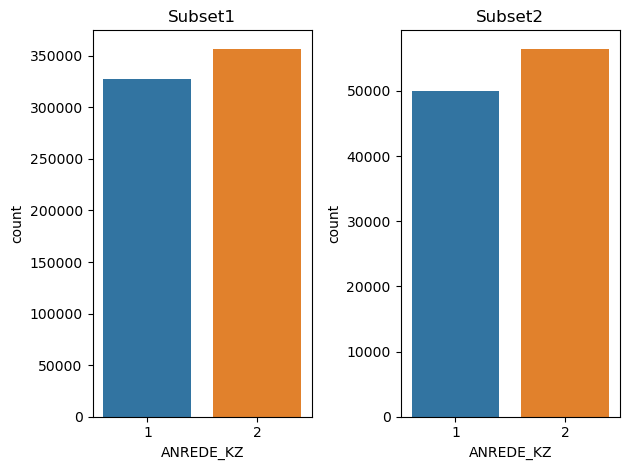

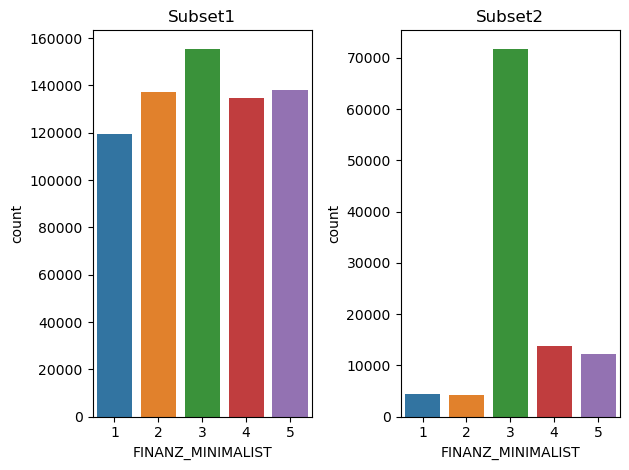

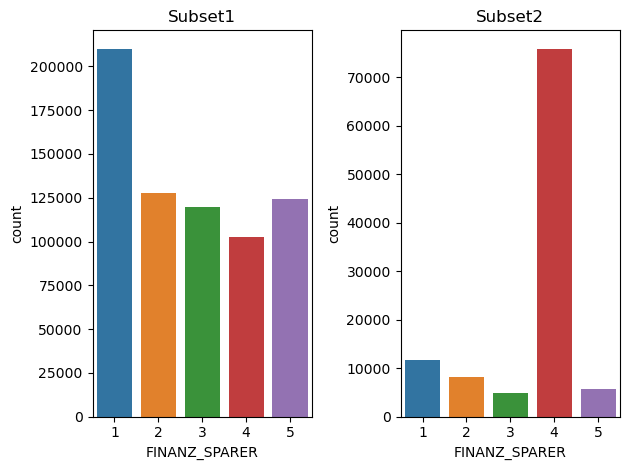

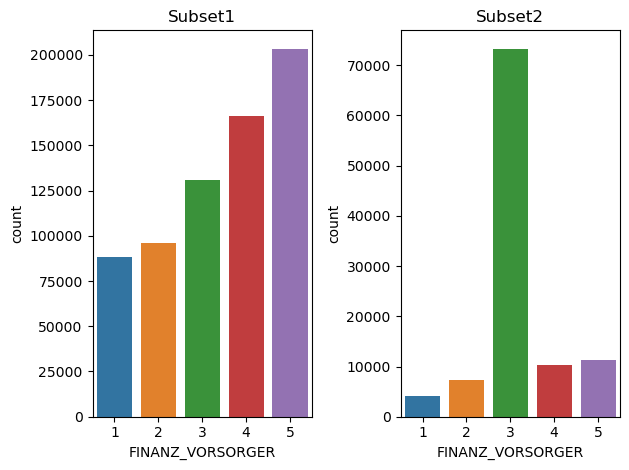

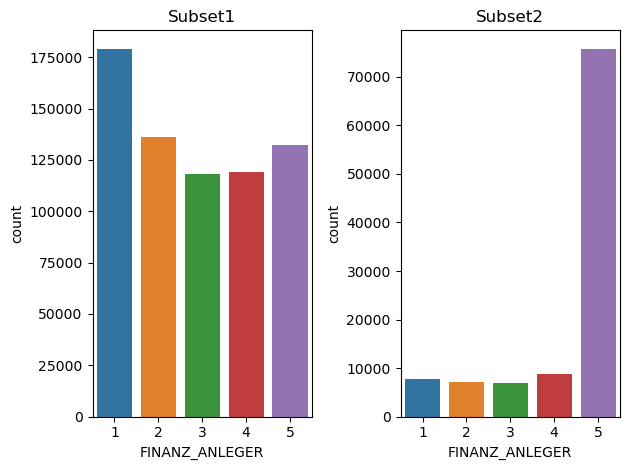

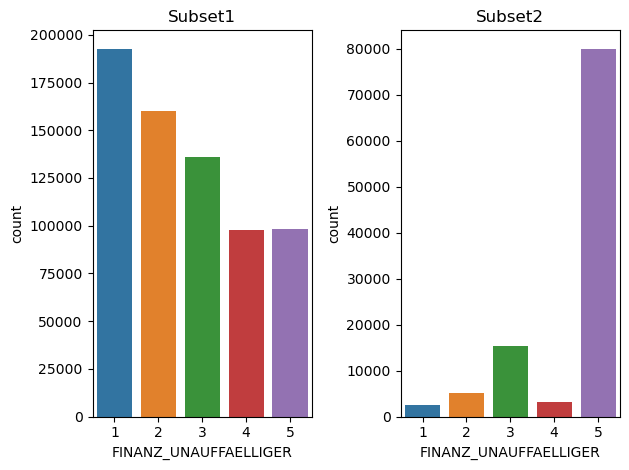

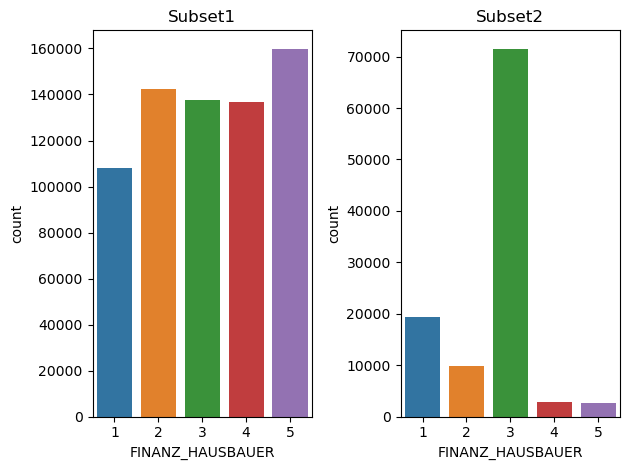

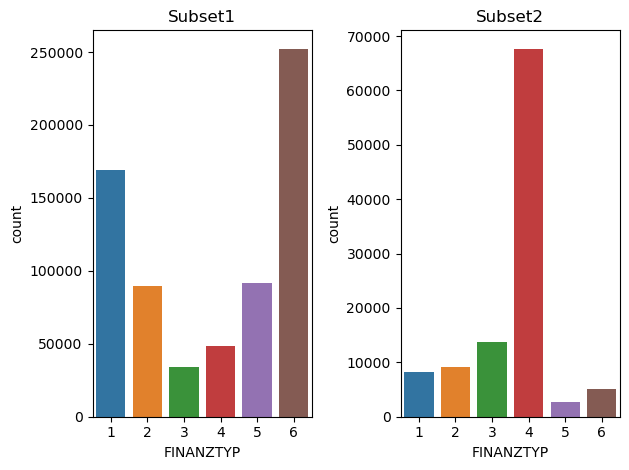

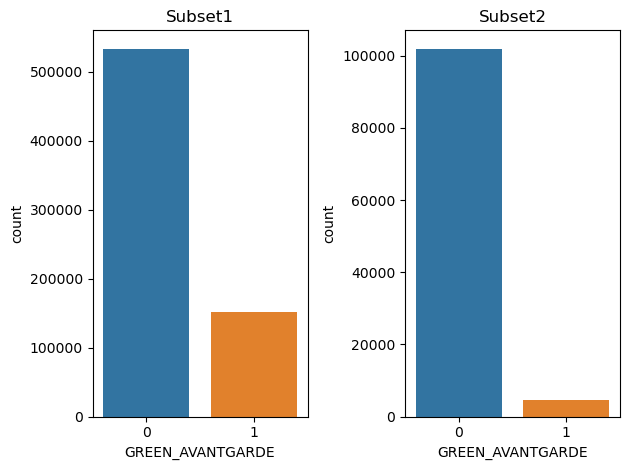

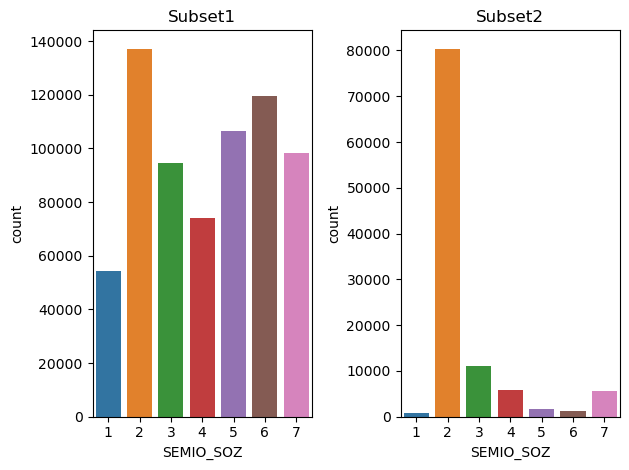

In [34]:
for i in dict_of_missing[0][0:10]:
    fig,ax=plt.subplots(1,2)
    ax[0].title.set_text("Subset1")
    ax[1].title.set_text("Subset2")
    sns.countplot(x=subset1[i],data=subset1,ax=ax[0])
    sns.countplot(x=subset2[i],data=subset2,ax=ax[1])
    plt.tight_layout()

#### Discussion: Assess Missing Data in Each Row

As we saw, rows with less than 11 missing values are able to include more than 87% of the data. Therefore we divided the data into two subsets with ~87% of the data being the subset of no or few missing values, and ~13% of the data points being the subset of more missing values.

Then we compared the distributions on each subset of 10 features that have zero missing values. For that purpose we used the dictionary dict_of_missing where groups of features with the same amount of missing values were stored.

By observing the results we can see that for most features the distributions show significant differences between the two subsets. 2 of them are very similar, like the GREEN_AVANTGARDE and the ANREDE_KZ. While some others show some similarities like the high Green column of FINANZ_MINIMALIST.

###  Select and Re-Encode Features

We need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [35]:
#Checking all the different kinds of types:

feat_info["type"].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [36]:
# How many features are there of each data type?

feat_info["type"].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

####  Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we will perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [37]:
#storing all categorical attributes from feat_info to a variable called categoricals

categoricals=feat_info[feat_info["type"]=='categorical']
categoricals

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [38]:
#Checking the kind of categoricals that exist in subset1 (subset without or few missing values) and storing them
#in a list.

categoricals_subset1=[]
for i in categoricals["attribute"]:
    if i not in subset1.columns:
        categoricals.drop(categoricals[categoricals["attribute"]==i].index.values[0],axis=0,inplace=True)
    else:
        print(i,subset1[i].unique())
        categoricals_subset1.append(i)
print("\nList of categorical features in subset1:",categoricals_subset1)

C:\Users\User\AppData\Local\Temp\ipykernel_9524\3731676761.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals.drop(categoricals[categoricals["attribute"]==i].index.values[0],axis=0,inplace=True)


ANREDE_KZ [2 1]
CJT_GESAMTTYP [5. 3. 2. 4. 1. 6.]
FINANZTYP [1 6 5 2 4 3]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.]
LP_STATUS_GROB [1. 2. 4. 5. 3.]
NATIONALITAET_KZ [ 1.  3.  2. nan]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
ZABEOTYP [5 3 4 1 6 2]
GEBAEUDETYP [8. 1. 3. 2. 6. 4.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]


C:\Users\User\AppData\Local\Temp\ipykernel_9524\3731676761.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals.drop(categoricals[categoricals["attribute"]==i].index.values[0],axis=0,inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9524\3731676761.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals.drop(categoricals[categoricals["attribute"]==i].index.values[0],axis=0,inplace=True)


CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']

List of categorical features in subset1: ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [39]:
#We will drop the attribute "CAMEO_DEU_2015" for the shake of simplicity
#as it appears to have too many levels in comparison to the rest
#of the features

subset1.drop("CAMEO_DEU_2015",axis=1,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_9524\980964946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset1.drop("CAMEO_DEU_2015",axis=1,inplace=True)


In [40]:
#We will also drop the feature "GEBAUDETYP" as by looking into the customer's data, it turned out that it included
#at least one level (5) that is no available in the customers' data

subset1.drop("GEBAEUDETYP",axis=1,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_9524\3087107597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset1.drop("GEBAEUDETYP",axis=1,inplace=True)


In [41]:
subset1.shape

(684568, 77)

In [42]:
#we will also remove these two features it from our list
categoricals_subset1.remove('CAMEO_DEU_2015')
categoricals_subset1.remove('GEBAEUDETYP')

In [43]:
#We notice that there is one binary categorical feature that doesn't take numerical values
#We will re encode it.

subset1["OST_WEST_KZ"]=subset1["OST_WEST_KZ"].map({'W':0,'O':1})

C:\Users\User\AppData\Local\Temp\ipykernel_9524\4012266197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset1["OST_WEST_KZ"]=subset1["OST_WEST_KZ"].map({'W':0,'O':1})


In [44]:
subset1.shape

(684568, 77)

In [45]:
#checking

subset1["OST_WEST_KZ"].unique()

array([0, 1], dtype=int64)

In [46]:
#Storing the multi level categories present in subset1 to a list

list_of_multi_cat=[]
for i in categoricals_subset1:
    if len(subset1[i].unique())>2:
        list_of_multi_cat.append(i)
        

In [47]:
list_of_multi_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'CAMEO_DEUG_2015']

In [48]:
#re encoding the multi level categorical features

subset1=pd.get_dummies(subset1,columns=list_of_multi_cat)

In [49]:
subset1.shape

(684568, 144)

#### Discussion: Re-Encode Categorical Features

There are 4 binary categorical features. One of them that did not contain numerical values was re encoded to values 0 and 1.
Out of the multi level categorical features, one was dropped for the shake of simplicity of the analysis as it appeared to have a significantly larger number of levels than the rest of the multi level features.

Finally, the attribute "GEBAUDETYP" was also dropped for the shake of simplicity as it is causing issues further into the analysis. At least one of the levels of this categorical variable (5) does not exist in the customer's data. Therefore when this attribute is being one hot encoded, we end up with an extra feature that has no meaning.

The rest of the multi level attributes were re encoded into the dataframe of none or few missing values, subset1, using pd.get_dummies()

#### Step: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention;
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [50]:
#Finding out which attributes are of mixed type

mixed=feat_info[feat_info["type"]=='mixed']
mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [51]:
subset1["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    156965
8.0     122028
10.0     73841
5.0      73572
3.0      46524
15.0     36142
11.0     30578
9.0      29303
6.0      22549
12.0     21053
4.0      17863
1.0      17708
2.0       6496
13.0      4859
7.0       3477
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [52]:
#By looking into the details of Data_Dictionary.md, we create a new column by replacing
#the corresponding values to the integer part of the decade (eg 40 from 40s)

subset1["PRAEGENDE_JUGENDJAHRE_Date"]=subset1["PRAEGENDE_JUGENDJAHRE"].replace([1,2],40)
subset1["PRAEGENDE_JUGENDJAHRE_Date"]=subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([3,4],50)
subset1["PRAEGENDE_JUGENDJAHRE_Date"]=subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([5,6,7],60)
subset1["PRAEGENDE_JUGENDJAHRE_Date"]=subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([8,9],70)
subset1["PRAEGENDE_JUGENDJAHRE_Date"]=subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([10,11,12,13],80)
subset1["PRAEGENDE_JUGENDJAHRE_Date"]=subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([14,15],90)

In [53]:
#checking

subset1["PRAEGENDE_JUGENDJAHRE_Date"].value_counts()

90.0    193107
70.0    151331
80.0    130331
60.0     99598
50.0     64387
40.0     24204
Name: PRAEGENDE_JUGENDJAHRE_Date, dtype: int64

In [54]:
#we do the same thing by creating a column for the movement. 
#This is a binary variable so we will replace the values with 0 and 1

subset1["PRAEGENDE_JUGENDJAHRE_Movement"]=subset1["PRAEGENDE_JUGENDJAHRE"].replace([1,3,5,8,10,12,14],0)
subset1["PRAEGENDE_JUGENDJAHRE_Movement"]=subset1["PRAEGENDE_JUGENDJAHRE_Movement"].replace([2,4,6,7,9,11,13,15],1)

In [55]:
#checking

subset1["PRAEGENDE_JUGENDJAHRE_Movement"].value_counts()

0.0    511691
1.0    151267
Name: PRAEGENDE_JUGENDJAHRE_Movement, dtype: int64

In [56]:
subset1.shape

(684568, 146)

In [57]:
#we will now drop the feature "PRAEGENDE_JUGENDJAHRE" as we do not need it anymore

subset1.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [58]:
#By looking into the data_dictionary, we see that the tens digits correspond to wealth and ones digits to life stage
#We replace them accordingly to new columns/features

subset1["CAMEO_INTL_2015_Wealth"]=subset1["CAMEO_INTL_2015"].replace(['11','12','13','14','15'],10)
subset1["CAMEO_INTL_2015_Wealth"]=subset1["CAMEO_INTL_2015_Wealth"].replace(['21','22','23','24','25'],20)
subset1["CAMEO_INTL_2015_Wealth"]=subset1["CAMEO_INTL_2015_Wealth"].replace(['31','32','33','34','35'],30)
subset1["CAMEO_INTL_2015_Wealth"]=subset1["CAMEO_INTL_2015_Wealth"].replace(['41','42','43','44','44','45'],40)
subset1["CAMEO_INTL_2015_Wealth"]=subset1["CAMEO_INTL_2015_Wealth"].replace(['51','52','53','54','55'],50)

In [59]:
#checking
subset1["CAMEO_INTL_2015_Wealth"].value_counts()

50.0    194809
40.0    164321
20.0    161911
10.0    102493
30.0     58092
Name: CAMEO_INTL_2015_Wealth, dtype: int64

In [60]:
subset1["CAMEO_INTL_2015_LifeStage"]=subset1["CAMEO_INTL_2015"].replace(['11','21','31','41','51'],1)
subset1["CAMEO_INTL_2015_LifeStage"]=subset1["CAMEO_INTL_2015_LifeStage"].replace(['12','22','32','42','52'],2)
subset1["CAMEO_INTL_2015_LifeStage"]=subset1["CAMEO_INTL_2015_LifeStage"].replace(['13','23','33','43','53'],3)
subset1["CAMEO_INTL_2015_LifeStage"]=subset1["CAMEO_INTL_2015_LifeStage"].replace(['14','24','34','44','54'],4)
subset1["CAMEO_INTL_2015_LifeStage"]=subset1["CAMEO_INTL_2015_LifeStage"].replace(['15','25','35','45','55'],5)

In [61]:
#checking
subset1["CAMEO_INTL_2015_LifeStage"].value_counts()

1.0    212316
4.0    200693
3.0    101361
5.0    100933
2.0     66323
Name: CAMEO_INTL_2015_LifeStage, dtype: int64

In [62]:
#We'll now drop the column "CAMEO_INTL_2015" as we do not need it
subset1.drop("CAMEO_INTL_2015",axis=1,inplace=True)

#### Discussion: Engineer Mixed-Type Features

By looking into the details of Data_Dictionary.md, we create a new column by replacing the values that correspond to each decade with the integer part of the decade (eg 40 for 40s)
Then we replace the rest of the values by modifying the same column for the rest of the decades.

The same process is followed for the movement variable but since it is binary so we just replace the values with 0 and 1.

Similarly for the CAMEO_INTL_2015, we divide into Wealth and LifeStage columns. 
We notice that the data in this feature are strings.
Since the tens of the values correspond to wealth, we replace each bunch of tens for each wealth category and the ones for each Life Stage.

Then the two initial columns are dropped since we do not need them anymore and they will interfere with the analysis later.

Every other mixed feature is kept as is.

####  Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [63]:
#we will one hot encode the new feature columns
subset1=pd.get_dummies(subset1,columns=["PRAEGENDE_JUGENDJAHRE_Date","CAMEO_INTL_2015_Wealth",
                                        "CAMEO_INTL_2015_LifeStage"])

In [64]:
subset1.shape

(684568, 159)

### Creating a Cleaning Function

In [65]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    
    
    for i in range(len(feat_info)):
        string=feat_info["missing_or_unknown"][i][1:len(feat_info["missing_or_unknown"][i])-1]
        List=string.split(',')
        
        manual_list=[]
        
        for j in List:
            try:
                x=int(j)
                manual_list.append(x)
            except:
                manual_list.append(j)
        feat_info["missing_or_unknown"][i]=manual_list

    
    
    for i in range(len(feat_info)):
        for j in feat_info["missing_or_unknown"][i]:
            df[df.columns[i]]=df[df.columns[i]].replace(j,np.nan)
            
    
    
    print('Total number of missing values after conversion is {}'.format(df.isnull().sum().sum()))
        
    
    # remove selected columns and rows, ...
    
    drop_columns=['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    
    for column in drop_columns:
        df.drop(labels=column,axis=1,inplace=True)
    
    
    
    
    rm=df.isna().sum(axis=1)
    
    threshold=1
    while True:
        percentage=0
        count=0
        for i in rm:
            if i<threshold:
                count+=1
        percentage=(count/len(rm))*100
        if percentage>85:
            break
        else:
            threshold=threshold+1
    
    new_subset1=df[rm<threshold]
    new_subset2=df[rm>=threshold]
    
    

    
    new_subset1.dropna(axis=0,subset=["SOHO_KZ"],inplace=True)
    new_subset1.dropna(axis=0,subset=["OST_WEST_KZ"],inplace=True)
    
    
        
    
    # select, re-encode, and engineer column values.
    
    new_categoricals=feat_info[feat_info["type"]=='categorical']
    
    new_categoricals_subset1=[]
    for i in new_categoricals["attribute"]:
        if i not in new_subset1.columns:
            new_categoricals.drop(new_categoricals[new_categoricals["attribute"]==i].index.values[0],axis=0,inplace=True)
        else:
            new_categoricals_subset1.append(i)
    
    new_subset1=new_subset1.drop("CAMEO_DEU_2015",axis=1)
    
    new_subset1.drop("GEBAEUDETYP",axis=1,inplace=True)
    
    
    new_categoricals_subset1.remove('CAMEO_DEU_2015')
    new_categoricals_subset1.remove('GEBAEUDETYP')
    
    new_subset1["OST_WEST_KZ"]=new_subset1["OST_WEST_KZ"].map({'W':0,'O':1})
    
    
    new_list_of_multi_cat=[]
    for i in new_categoricals_subset1:
        if len(new_subset1[i].unique())>2:
            new_list_of_multi_cat.append(i)
            
    new_subset1=pd.get_dummies(new_subset1,columns=new_list_of_multi_cat)
    
    
    new_subset1["PRAEGENDE_JUGENDJAHRE_Date"]=new_subset1["PRAEGENDE_JUGENDJAHRE"].replace([1,2],40)
    new_subset1["PRAEGENDE_JUGENDJAHRE_Date"]=new_subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([3,4],50)
    new_subset1["PRAEGENDE_JUGENDJAHRE_Date"]=new_subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([5,6,7],60)
    new_subset1["PRAEGENDE_JUGENDJAHRE_Date"]=new_subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([8,9],70)
    new_subset1["PRAEGENDE_JUGENDJAHRE_Date"]=new_subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([10,11,12,13],80)
    new_subset1["PRAEGENDE_JUGENDJAHRE_Date"]=new_subset1["PRAEGENDE_JUGENDJAHRE_Date"].replace([14,15],90)
    
    new_subset1["PRAEGENDE_JUGENDJAHRE_Movement"]=new_subset1["PRAEGENDE_JUGENDJAHRE"].replace([1,3,5,8,10,12,14],0)
    new_subset1["PRAEGENDE_JUGENDJAHRE_Movement"]=new_subset1["PRAEGENDE_JUGENDJAHRE_Movement"].replace([2,4,6,7,9,11,13,15],1)
    
    new_subset1.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
    
    
    new_subset1["CAMEO_INTL_2015_Wealth"]=new_subset1["CAMEO_INTL_2015"].replace(['11','12','13','14','15'],10)
    new_subset1["CAMEO_INTL_2015_Wealth"]=new_subset1["CAMEO_INTL_2015_Wealth"].replace(['21','22','23','24','25'],20)
    new_subset1["CAMEO_INTL_2015_Wealth"]=new_subset1["CAMEO_INTL_2015_Wealth"].replace(['31','32','33','34','35'],30)
    new_subset1["CAMEO_INTL_2015_Wealth"]=new_subset1["CAMEO_INTL_2015_Wealth"].replace(['41','42','43','44','44','45'],40)
    new_subset1["CAMEO_INTL_2015_Wealth"]=new_subset1["CAMEO_INTL_2015_Wealth"].replace(['51','52','53','54','55'],50)
    
    new_subset1["CAMEO_INTL_2015_LifeStage"]=new_subset1["CAMEO_INTL_2015"].replace(['11','21','31','41','51'],1)
    new_subset1["CAMEO_INTL_2015_LifeStage"]=new_subset1["CAMEO_INTL_2015_LifeStage"].replace(['12','22','32','42','52'],2)
    new_subset1["CAMEO_INTL_2015_LifeStage"]=new_subset1["CAMEO_INTL_2015_LifeStage"].replace(['13','23','33','43','53'],3)
    new_subset1["CAMEO_INTL_2015_LifeStage"]=new_subset1["CAMEO_INTL_2015_LifeStage"].replace(['14','24','34','44','54'],4)
    new_subset1["CAMEO_INTL_2015_LifeStage"]=new_subset1["CAMEO_INTL_2015_LifeStage"].replace(['15','25','35','45','55'],5)
    
    new_subset1.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    
    
    new_subset1=pd.get_dummies(new_subset1,columns=["PRAEGENDE_JUGENDJAHRE_Date","CAMEO_INTL_2015_Wealth","CAMEO_INTL_2015_LifeStage"])
    
    
    new_subset1.dropna(axis=1,how='all',inplace=True)
    
    
    # Return the cleaned dataframe.
    
    return new_subset1
    
    

##  Feature Transformation

### Applying Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [66]:
subset1.isna().sum().sum()

452548

In [67]:
subset1.shape

(684568, 159)

In [68]:
subset1.dropna(axis=1,how='all',inplace=True)
subset1.dropna(axis=0,how='all',inplace=True)

In [69]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
Imp_mean=SimpleImputer(strategy='mean')
X=Imp_mean.fit_transform(subset1)
X=pd.DataFrame(X,columns=subset1.columns)

In [70]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler()
X_ss=scaler.fit_transform(X)

In [71]:
X_ss=pd.DataFrame(X_ss,columns=subset1.columns)

### Discussion: Apply Feature Scaling

First we tried dropna to drop rows and columns that potentially could have remained with only nan values.
Then the rest of the missing values are filled with the mean, along columns, using an Imputer. It is probably a better decision as dropping completely the data points would have negative repercusions in our analysis.

We also use the subset1 data set which is already the set with reduced missing values.

Then the features are scaled, using a Standard Scaler

### Performing Dimensionality Reduction


In [72]:
# Apply PCA to the data.
pca=PCA()
X_pca=pca.fit_transform(X_ss)


In [73]:
X_pca.shape

(684568, 159)

In [108]:
# Investigate the variance accounted for by each principal component.

from kneed import KneeLocator

def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)

    # Detect the elbow point
    kneedle = KneeLocator(ind, cumvals, curve='concave', direction='increasing')
    elbow_point = kneedle.elbow

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if elbow_point is not None:
        # Add the vertical line
        ax.axvline(x=elbow_point, color='red', linestyle='--')

        # Annotate the plot with the elbow point information
        ax.annotate('Elbow Point: {} \nCumulative Explained Variance: {:.2f}%'.format(elbow_point, cumvals[elbow_point]*100),
                    xy=(elbow_point, cumvals[elbow_point]), xycoords='data',
                    xytext=(elbow_point+10, cumvals[elbow_point]), textcoords='data',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

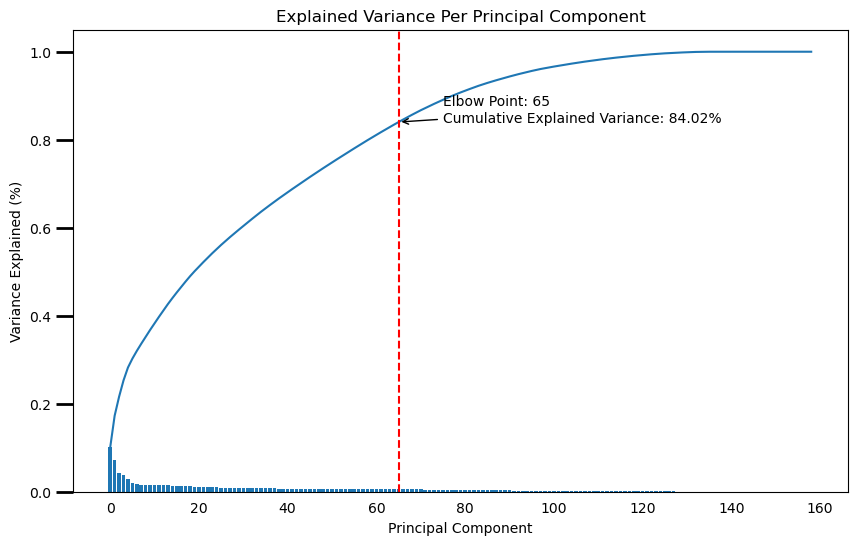

In [109]:
scree_plot(pca)

In [111]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance[65]

0.840177670003224

In [115]:
def scree_plot2(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [112]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca=PCA(n_components=65)
X_pca=pca.fit_transform(X_ss)


In [117]:
X_pca.shape

(684568, 66)

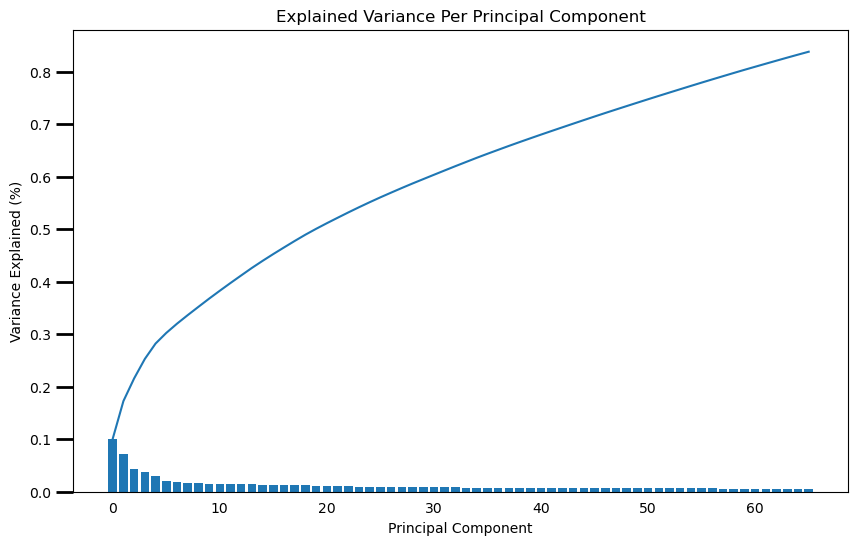

In [118]:
scree_plot2(pca)

### Discussion: Perform Dimensionality Reduction

From the 2 scree plots we can see that 100% of the variance is explained at around 130 principal components. While more than 80% could be explained with just 65 variables. This is the elbow point where the variance starts levelling off. Therefore we decided to reduce the components by half.

### Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.


- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. We will use the data dictionary document to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component.

In [125]:

def mapping_weights(pca,number):
    components=pca.components_
    components_df=pd.DataFrame(components,columns=X_ss.keys())
    map_dict={}
    for j in range(len(components_df.columns)):
        map_dict[components_df.columns[j]]= components_df.iloc[number,j]
    sorted_keys=sorted(map_dict,key=map_dict.get)
    sorted_dict={}
    for w in sorted_keys:
        sorted_dict[w]=map_dict[w]
    return sorted_dict

In [126]:
#calculating explained variance

ratios=pca.explained_variance_ratio_
ratios_pd=pd.DataFrame(ratios)

In [127]:
ratios_pd.head(10)

,0
0,0.100932
1,0.071805
2,0.043172
3,0.037088
4,0.029255
5,0.020249
6,0.017576
7,0.016306
8,0.015792
9,0.015621


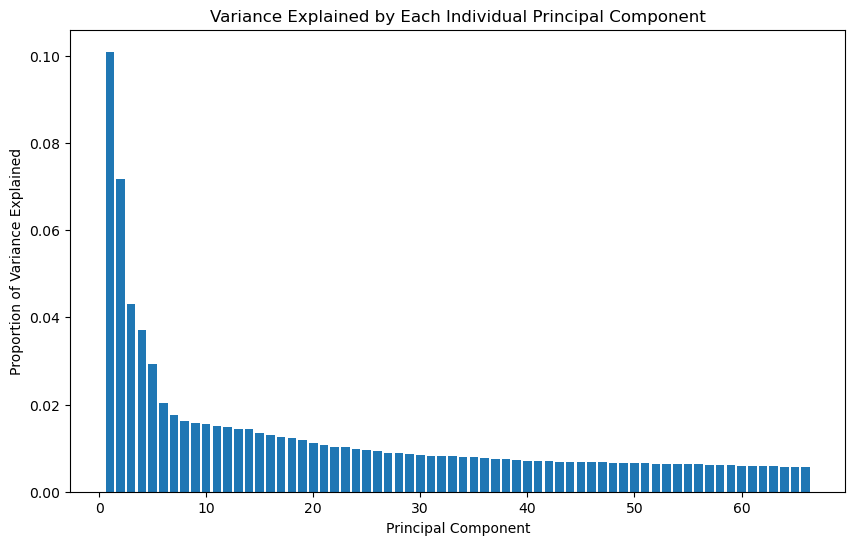

In [128]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Variance Explained by Each Individual Principal Component')
plt.show()

We will proceed by calculating the weights of each feature for the first 3 components.
We're plotting the 30 largest ones:

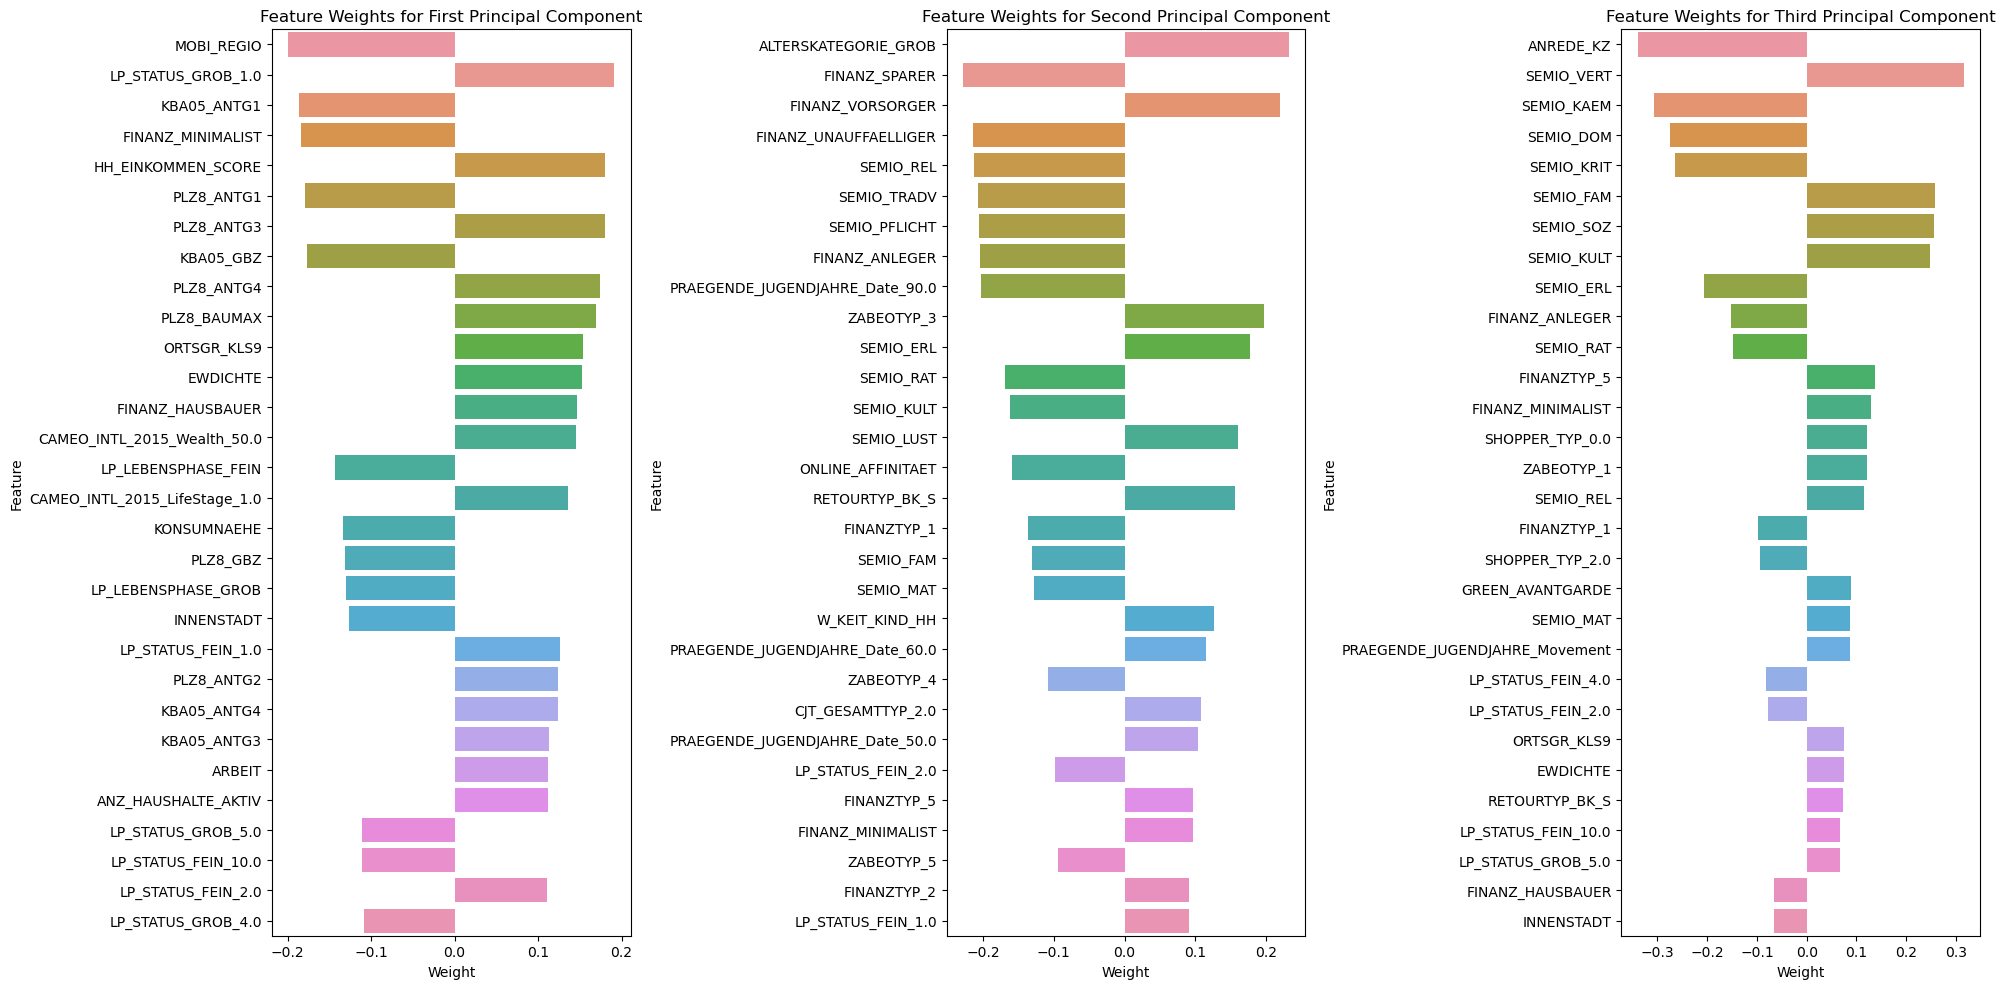

In [148]:
weights_pc1 = mapping_weights(pca, 0)
weights_pc2 = mapping_weights(pca, 1)
weights_pc3 = mapping_weights(pca, 2)


weights_df_pc1 = pd.DataFrame(list(weights_pc1.items()), columns=['Feature', 'Weight'])
weights_df_pc2 = pd.DataFrame(list(weights_pc2.items()), columns=['Feature', 'Weight'])
weights_df_pc3 = pd.DataFrame(list(weights_pc3.items()), columns=['Feature', 'Weight'])


weights_df_pc1['abs_weight'] = weights_df_pc1['Weight'].abs()
weights_df_pc2['abs_weight'] = weights_df_pc2['Weight'].abs()
weights_df_pc3['abs_weight'] = weights_df_pc3['Weight'].abs()

weights_df_pc1 = weights_df_pc1.sort_values('abs_weight', ascending=False)
weights_df_pc2 = weights_df_pc2.sort_values('abs_weight', ascending=False)
weights_df_pc3 = weights_df_pc3.sort_values('abs_weight', ascending=False)


weights_df_pc1 = weights_df_pc1.head(30)
weights_df_pc2 = weights_df_pc2.head(30)
weights_df_pc3 = weights_df_pc3.head(30)


fig, axes = plt.subplots(1, 3, figsize=(20,10))

sns.barplot(ax=axes[0], x='Weight', y='Feature', data=weights_df_pc1)
axes[0].set_title('Feature Weights for First Principal Component')

sns.barplot(ax=axes[1], x='Weight', y='Feature', data=weights_df_pc2)
axes[1].set_title('Feature Weights for Second Principal Component')

sns.barplot(ax=axes[2], x='Weight', y='Feature', data=weights_df_pc3)
axes[2].set_title('Feature Weights for Third Principal Component')

plt.tight_layout()
plt.show()

### Discussion: Interpret Principal Components

By investigating the explained variance ratios, we are able to see that 83.27% total variance is explained by the 65 components.

The first component explains 10.13% of total variance.
The second component explains 7.22% of total variance.
The third component explains 4.3% of total variance.

1st component:

By investigating further the weights of the first component, we are able to see that the top features are;


'PLZ8_BAUMAX': 0.16
'PLZ8_ANTG4': 0.17
PLZ8_ANTG3': 0.17
'HH_EINKOMMEN_SCORE': 0.18
'LP_STATUS_GROB_1.0': 0.19

Which mostly translate to Social status, size of family and their estimated incomes. Specifically, LP_STATUS_GROB_1 PLZ8_ANTG3 and 4 are about 6-10 and 10+ family homes. While the PLZ8_BAUMAX feature is about the the type of buildings in the region, whether they are family ones or business buildings.
So, we can see that for the first component, features related to Family and their income/status are the most positively weighted.

On the other hand, the top negatively weighted features are:


 'MOBI_REGIO': -0.199
 'KBA05_ANTG1': -0.186
 'FINANZ_MINIMALIST': -0.184
 'PLZ8_ANTG1': -0.179
 'KBA05_GBZ': -0.177
 
 Which are about movement patterns, number of 1-2 family houses in the microcell, number of 1-2 family houses in the PLZ8 region, number of buildings in the region and financial typology. By comparing their respective values with the top positively weighted features, we can see that there's probably a prevalence of buildings of smaller family capacity.
 
 
 2nd component:
 
 For the second component, the top positively weighted features are 
 
  'SEMIO_LUST': 0.161
 'SEMIO_ERL': 0.177
 'ZABEOTYP_3': 0.196
 'FINANZ_VORSORGER': 0.219
 'ALTERSKATEGORIE_GROB': 0.232
 
 Which translate to estimated age, financial typology for vorosrger, energy consumption typology 3, and personality typology 'LUST'.
 
 Top negatively weighted features:
 
 'FINANZ_SPARER': -0.228
 'FINANZ_UNAUFFAELLIGER': -0.214
 'SEMIO_REL': -0.213
 'SEMIO_TRADV': -0.206
 'SEMIO_PFLICHT': -0.205
 'FINANZ_ANLEGER': -0.204
 
 Again here, the most negatively weighted features are about financial typology and personality typology.
 
 
 3rd component:
 
 Top positive:
 
 'FINANZ_MINIMALIST': 0.129
 'FINANZTYP_5': 0.136
 'SEMIO_KULT': 0.248
 'SEMIO_SOZ': 0.255
 'SEMIO_FAM': 0.256
 'SEMIO_VERT': 0.315
 
 Similarly to the second component, the top positively weighted features are about the personality typology and financial typology.
 
 Top negative:
 
'ANREDE_KZ': -0.339
 'SEMIO_KAEM': -0.307
 'SEMIO_DOM': -0.273
 'SEMIO_KRIT': -0.263
 'SEMIO_ERL': -0.206
 'FINANZ_ANLEGER': -0.152
 'SEMIO_RAT': -0.148
 'FINANZTYP_1': -0.098
 
 The top negative feature is about gender while the rest ones are again about personality and financial types.
 
 
We can conclude by the examination of those principal components that they can indeed be interpreted in a meaningful way. The positive and negative weights show the negative correlations between the attributes which in those components had mostly to do with family types, personality and financial typology. Specific groups of features seem to contribute more in explaining the variance of those components.

## Clustering

###  Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.


In [87]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
scores=[]
for i in range(1,20,2):
    kmeans=KMeans(n_clusters=i)
    model=kmeans.fit(X_pca)
    score=np.abs(model.score(X_pca))
    print(score/X_pca.shape[0], "for n_clusters=",i)
    scores.append(score)
    
    
    

c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


132.3370923291703 for n_clusters= 1


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


114.18660312685839 for n_clusters= 3


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


107.27707893898688 for n_clusters= 5


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


103.68202849340936 for n_clusters= 7


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


101.19053646738136 for n_clusters= 9


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


98.52337167381471 for n_clusters= 11


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


96.34141664921137 for n_clusters= 13


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


94.4262320376559 for n_clusters= 15


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


93.16597890211855 for n_clusters= 17


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


91.58481544401181 for n_clusters= 19


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_k

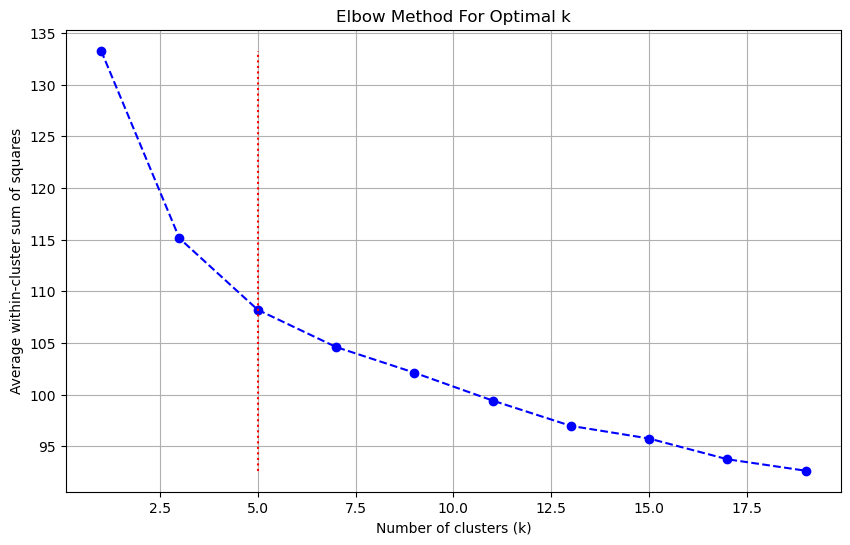

The elbow point is at k = 5


In [151]:
scores = []
clusters = range(1, 20, 2)
for i in clusters:
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(X_pca)
    score = np.abs(model.score(X_pca)) / X_pca.shape[0]
    scores.append(score)


kl = KneeLocator(clusters, scores, curve="convex", direction="decreasing")
elbow_point = kl.elbow

# Elbow plot
plt.figure(figsize=(10,6))
plt.plot(clusters, scores, linestyle='--', marker='o', color='b')
plt.vlines(elbow_point, min(scores), max(scores), colors='r', linestyles='dotted')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

print(f"The elbow point is at k = {elbow_point}")

In [153]:
# Investigate the change in within-cluster distance across number of clusters.

#clusters=[1,3,5,7,9,11,13,15,17,19]
#plt.plot(clusters,scores,linestyle='--',marker='o',color='r')
#plt.xlabel('K')
#plt.ylabel('SSE')
#plt.title('SSE vs K')


In [154]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
new_kmeans=KMeans(n_clusters=5)
new_model=new_kmeans.fit(X_pca)

predictions=new_model.predict(X_pca)


c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [157]:
predictions

array([0, 4, 3, ..., 2, 4, 2])

### Discussion Apply Clustering to General Population

We can see from the graph that as K points increases, the distance from the centers are decreased. By the elbow method we can see that after 5 clusters the distance decreases significantly less with every extra cluster. k = 5 clusters are picked

### Applying All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. 

In [158]:
# Loading in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [159]:
# Applying preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_customers=clean_data(customers)

Total number of missing values after conversion is 3112918


C:\Users\User\AppData\Local\Temp\ipykernel_9524\2724750418.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_subset1.dropna(axis=0,subset=["SOHO_KZ"],inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9524\2724750418.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_subset1.dropna(axis=0,subset=["OST_WEST_KZ"],inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9524\2724750418.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [160]:
clean_customers.shape

(141725, 159)

In [161]:
clean_customers.isna().sum().sum()

121873

In [162]:
Imputed_clean_customers=Imp_mean.transform(clean_customers)

In [163]:
scaled_imputed_clean_customers= scaler.transform(Imputed_clean_customers)

c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [164]:
pca_customers=pca.transform(scaled_imputed_clean_customers)

c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [165]:
predictions_customers=new_model.predict(pca_customers)

In [166]:
predictions_customers

array([1, 1, 3, ..., 1, 3, 3])

###  Comparing Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final step, we will compare the two cluster distributions to see where the strongest customer base for the company is.


In [167]:
predictions.shape

(684568,)

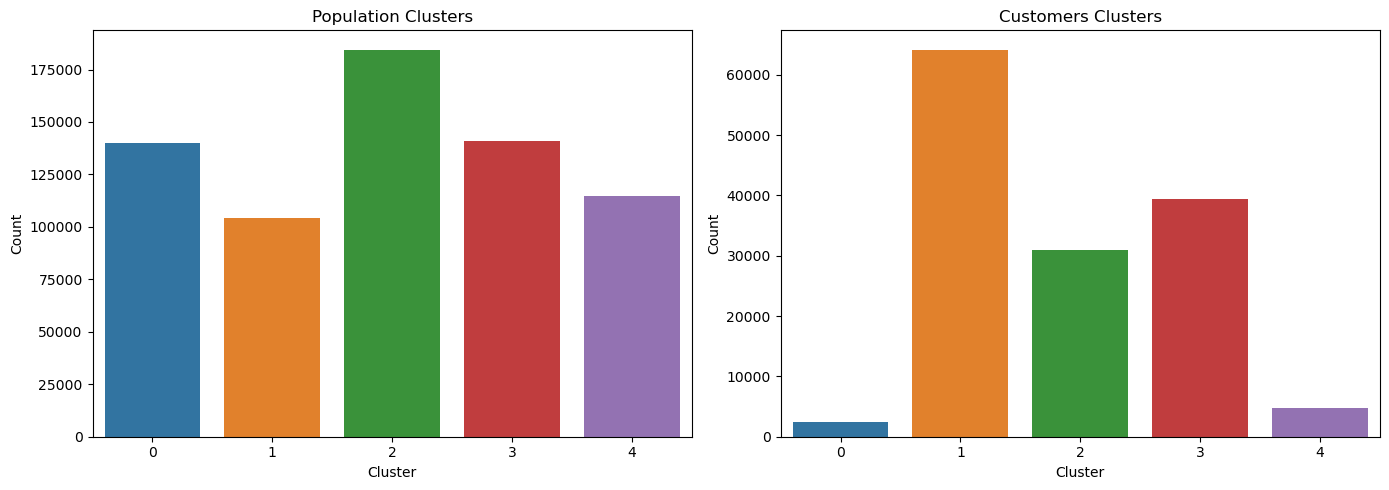

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=predictions, ax=ax[0])
ax[0].set_title('Population Clusters')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Count')

sns.countplot(x=predictions_customers, ax=ax[1])
ax[1].set_title('Customers Clusters')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [175]:
preds_pop=pd.Series(predictions).value_counts().sort_index()

In [176]:
preds_pop

0    140129
1    104145
2    184447
3    140948
4    114899
dtype: int64

In [177]:
preds_customers=pd.Series(predictions_customers).value_counts().sort_index()

In [178]:
preds_customers

0     2483
1    64142
2    30951
3    39447
4     4702
dtype: int64

In [183]:
dataframe=pd.DataFrame({'Predictions on Population':preds_pop,'Predictions on Customers':preds_customers})

In [184]:
dataframe['Pop_ratio']=dataframe["Predictions on Population"]/dataframe["Predictions on Population"].sum()
dataframe['Customer_ratios']=dataframe["Predictions on Customers"]/dataframe["Predictions on Customers"].sum()

In [185]:
dataframe.head()

,Predictions on Population,Predictions on Customers,Pop_ratio,Customer_ratios
0,140129,2483,0.204697,0.017520
1,104145,64142,0.152132,0.452581
2,184447,30951,0.269436,0.218388
3,140948,39447,0.205893,0.278335
4,114899,4702,0.167842,0.033177


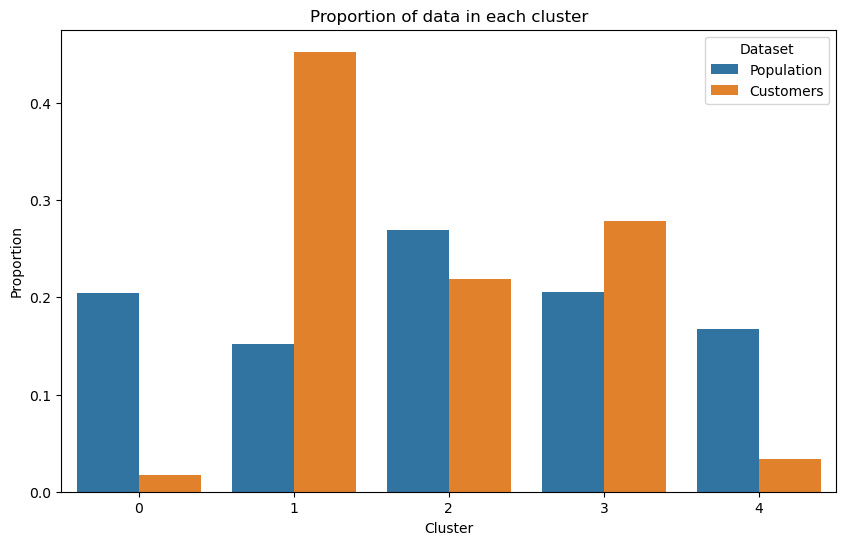

In [182]:
population_counts = np.bincount(predictions)
customer_counts = np.bincount(predictions_customers)

population_proportions = population_counts / population_counts.sum()
customer_proportions = customer_counts / customer_counts.sum()


proportions_df = pd.DataFrame({
    'Cluster': np.arange(len(population_proportions)),
    'Population': population_proportions,
    'Customers': customer_proportions
})


proportions_melted = proportions_df.melt(id_vars='Cluster', var_name='Dataset', value_name='Proportion')


plt.figure(figsize=(10,6))
sns.barplot(x='Cluster', y='Proportion', hue='Dataset', data=proportions_melted)
plt.title('Proportion of data in each cluster')
plt.show()

In [112]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [193]:
cluster_centers_pca = new_model.cluster_centers_

In [194]:
# First, use PCA's inverse_transform to get back to the standardized feature space
cluster_centers_ss = pca.inverse_transform(cluster_centers_pca)

# Then, use the StandardScaler's inverse_transform to get back to the original feature space
cluster_centers = scaler.inverse_transform(cluster_centers_ss)

In [202]:



#REFERENCE: https://stackoverflow.com/questions/49885007/how-to-use-scikit-learn-inverse-transform-with-new-values

In [203]:
cluster_centers_ss.shape

(5, 159)

In [204]:
cluster_centers_ss=pd.DataFrame(inversed,columns=subset1.columns)

In [205]:
#From the bar plots above and the data frame that matches each cluster with the features it encompasses, we can see
# that there are a few clusters that are overrepresented in the customers' set
#these are clusters 1 and 3

cluster_centers_ss

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_INTL_2015_Wealth_10.0,CAMEO_INTL_2015_Wealth_20.0,CAMEO_INTL_2015_Wealth_30.0,CAMEO_INTL_2015_Wealth_40.0,CAMEO_INTL_2015_Wealth_50.0,CAMEO_INTL_2015_LifeStage_1.0,CAMEO_INTL_2015_LifeStage_2.0,CAMEO_INTL_2015_LifeStage_3.0,CAMEO_INTL_2015_LifeStage_4.0,CAMEO_INTL_2015_LifeStage_5.0
0,1.855091,1.574242,1.413324,4.433408,2.118992,4.039815,3.808018,4.068632,0.065998,2.273783,...,0.018137,0.045611,0.072323,0.286140,0.575082,0.602792,0.067658,0.071264,0.173062,0.082518
1,3.216381,1.475381,4.486999,1.813303,4.026410,1.956094,2.289310,2.032962,0.968252,2.117580,...,0.428612,0.318573,0.077555,0.129601,0.042201,0.071134,0.104774,0.173524,0.447775,0.199336
2,3.390529,1.516874,2.889156,1.877496,4.294724,1.855196,1.689587,3.912229,0.079342,2.188286,...,0.027347,0.059891,0.080972,0.314774,0.513877,0.489419,0.049347,0.075036,0.203990,0.179067
3,3.366247,1.500760,4.217499,1.698471,4.240928,2.501730,1.791102,2.486223,0.026784,2.199818,...,0.185550,0.446697,0.094015,0.205536,0.060892,0.111603,0.139086,0.232370,0.356325,0.153306
4,1.906045,1.530132,2.573167,4.011434,2.152649,4.163678,4.061908,2.586612,0.198526,2.232936,...,0.210108,0.420906,0.101791,0.206168,0.055864,0.125283,0.149956,0.232571,0.365356,0.121671


In [117]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Under-represented clusters: 0 and 4



In [192]:
#0 cluster

mapping_weights(pca,0)

{'MOBI_REGIO': -0.19951289619072848,
 'KBA05_ANTG1': -0.1864350771428546,
 'FINANZ_MINIMALIST': -0.18393805622613835,
 'PLZ8_ANTG1': -0.1799572123197482,
 'KBA05_GBZ': -0.17730868632853397,
 'LP_LEBENSPHASE_FEIN': -0.14392565280812997,
 'KONSUMNAEHE': -0.13335816889120655,
 'PLZ8_GBZ': -0.13178640767593822,
 'LP_LEBENSPHASE_GROB': -0.13058498642283253,
 'INNENSTADT': -0.12622462877723828,
 'LP_STATUS_FEIN_10.0': -0.11119828420279564,
 'LP_STATUS_GROB_5.0': -0.11119828420279564,
 'LP_STATUS_GROB_4.0': -0.10921228404033592,
 'LP_STATUS_FEIN_9.0': -0.107843245225834,
 'CAMEO_INTL_2015_Wealth_20.0': -0.10309540238214032,
 'GREEN_AVANTGARDE': -0.10147773342368582,
 'PRAEGENDE_JUGENDJAHRE_Movement': -0.0992450103108085,
 'CAMEO_INTL_2015_Wealth_10.0': -0.09756559856204128,
 'ZABEOTYP_1': -0.09547240184934806,
 'ANZ_PERSONEN': -0.09524324402205114,
 'BALLRAUM': -0.0951506601626992,
 'GEBAEUDETYP_RASTER': -0.09244795459808966,
 'CAMEO_DEUG_2015_2': -0.08389814569724317,
 'LP_FAMILIE_GROB_5.0':

In [208]:
mapping_weights(pca,1)

{'FINANZ_SPARER': -0.22858168648644495,
 'FINANZ_UNAUFFAELLIGER': -0.21457724068633668,
 'SEMIO_REL': -0.21323299414886712,
 'SEMIO_TRADV': -0.20657206540972345,
 'SEMIO_PFLICHT': -0.20598868890105282,
 'FINANZ_ANLEGER': -0.20467543397520707,
 'PRAEGENDE_JUGENDJAHRE_Date_90.0': -0.20302122162422206,
 'SEMIO_RAT': -0.16925817737196525,
 'SEMIO_KULT': -0.16175925813313372,
 'ONLINE_AFFINITAET': -0.1597858017967288,
 'FINANZTYP_1': -0.136424126025542,
 'SEMIO_FAM': -0.13064240952309716,
 'SEMIO_MAT': -0.12864906395460338,
 'ZABEOTYP_4': -0.10766518659979411,
 'LP_STATUS_FEIN_2.0': -0.09870916567616057,
 'ZABEOTYP_5': -0.09357639532660884,
 'FINANZTYP_4': -0.08873981552724348,
 'LP_STATUS_FEIN_5.0': -0.0801579720846788,
 'GFK_URLAUBERTYP_9.0': -0.07364122207393328,
 'FINANZTYP_3': -0.07134280881155779,
 'LP_FAMILIE_GROB_4.0': -0.06772459939741822,
 'ANZ_PERSONEN': -0.06715860175213366,
 'SEMIO_SOZ': -0.06031081396426948,
 'PLZ8_ANTG1': -0.057215490679211715,
 'KBA05_GBZ': -0.05415604123923

In [207]:
#4 cluster
mapping_weights(pca,4)

{'PRAEGENDE_JUGENDJAHRE_Movement': -0.25110851772994575,
 'GREEN_AVANTGARDE': -0.24981783011565767,
 'LP_FAMILIE_FEIN_1.0': -0.2139951643927413,
 'LP_FAMILIE_GROB_1.0': -0.2139951643927413,
 'LP_STATUS_FEIN_10.0': -0.19337743836238558,
 'LP_STATUS_GROB_5.0': -0.19337743836238558,
 'CAMEO_INTL_2015_Wealth_10.0': -0.14329089967507552,
 'W_KEIT_KIND_HH': -0.13805202651790008,
 'FINANZ_UNAUFFAELLIGER': -0.10885471310524884,
 'CAMEO_DEUG_2015_1': -0.10661003728136437,
 'LP_STATUS_FEIN_3.0': -0.1053176265941743,
 'PLZ8_GBZ': -0.09625193229999124,
 'EWDICHTE': -0.09461919670992057,
 'CAMEO_DEUG_2015_2': -0.0944856008408256,
 'PLZ8_HHZ': -0.09286882851537301,
 'ORTSGR_KLS9': -0.08454990260016858,
 'SEMIO_DOM': -0.0802065404077528,
 'LP_STATUS_GROB_2.0': -0.07624772532430399,
 'KBA05_ANTG1': -0.07587923494999495,
 'CAMEO_INTL_2015_LifeStage_4.0': -0.07551049296309345,
 'KBA13_ANZAHL_PKW': -0.0741623405342428,
 'FINANZTYP_5': -0.07347957403436502,
 'SEMIO_TRADV': -0.06789189619091097,
 'SEMIO_KR

### Discussion: Compare Customer Data to Demographics Data

By evaluating the count and bar plots above, we can see that the company's customer base is not universal. There is some mismatch between segments of population. 

Some of those segments seem to be overrepresented in the customer data which indicates that they are groups that the company should target.

While other segments appear to be underrepresented in the customer data which indicate that these groups of people are outside the company's target demographics.

Particular groups that seem to be overrepresented in the customer data and the company should target is being represented by the clusters 1 and 2.
By looking into the the dictionary that we created at 2.3 we can easily see that these groups of people has some prevalent characteristic that puts them apart from the apart and the company could look into them further.


Uderrepresented groups in the customer data that lie outside the company's target are the clusters 0 and 4 which also show some prevalent features/weights that could be found useful by the company.
For instance, they are multi-person housholds.